# Quantitative exercise - Make3D dataset

The goal of this exercise is computing some initial analysis and statistics of the datasets we identified for our project.

Our project concerns depth prediction from monocular 2D images: the independant variable are the images (usually in PNG or JPG format), whereas the dependant variable is the depth information (in meters). The ground truth depth information is usually computed from laser scanners. Nowadays the technology has become quite accurate, for example in systems such as [LiDAR](https://en.wikipedia.org/wiki/Lidar). In the case of this preliminary analysis, the dataset is quite old (approximately 2005) and a different laser scanner was used.

You can reproduce these results by downloading and extracting the [Make3D](http://make3d.cs.cornell.edu/data.html) dataset in the `images` folder before running this notebook.  
You will need both training images and the respective depth maps from Dataset 1.


#### Author: Andrea Nardelli

First, import packages.

In [1]:
%matplotlib inline

from pathlib import Path
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import zoom
from scipy.stats import describe
import numpy as np

## Exploratory analysis

First of all, I will create an iterator over the images that we have.   
They should be in the `./images/` folder and the depths in the `./images/Train400Depth/` folder.

In [2]:
p = Path('images')
images = list(p.glob('*.jpg'))

Read and show the first image.

(2272, 1704, 3)


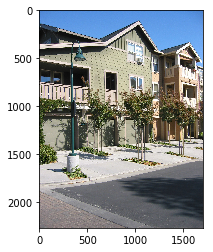

In [3]:
img_path = images[0]

img_data = plt.imread(img_path)
plt.imshow(img_data)

print(img_data.shape)

The images are 2272x1704 JPG files with RGB channels.  
We can find the corresponding depth map from the path of the image. They are saved as `.mat` files from MatLab.   
The depth information is in the `Position3DGrid` attribute, which is also a 3D array. The actual depth information in meters is in the last channel.   

[[18.5   18.35  18.25  ... 80.    80.    80.   ]
 [19.45  19.405 19.26  ... 80.    80.    80.   ]
 [19.35  19.35  19.285 ... 80.    80.    80.   ]
 ...
 [ 4.99   4.99   4.99  ...  4.6    4.61   4.61 ]
 [ 4.75   4.99   4.75  ...  4.42   4.42   4.42 ]
 [ 4.75   4.75   4.75  ...  4.42   4.42   4.42 ]]


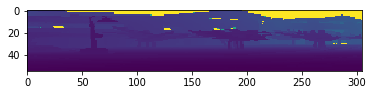

In [4]:
depth_mat = loadmat(f'images/Train400Depth/depth_sph_corr{img_path.stem[3:]}.mat')

depth_data = depth_mat['Position3DGrid'][:,:,-1]
print(depth_data)

plt.imshow(depth_data)

It seems that the y-resolution of the laser scanner is very low. We can scale the image for visualization purposes.

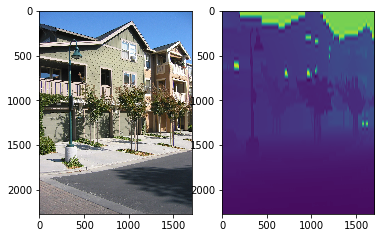

In [5]:
img_width, img_height = img_data.shape[:-1]
depth_width, depth_height = depth_data.shape

plt.subplot(121)
plt.imshow(img_data)
plt.subplot(122)
plt.imshow(zoom(depth_data, (img_width/depth_width, img_height/depth_height)))

## Statistical analysis

After the first analysis, we can define some helper functions that open an image and its corresponding depth map, scaling it to have the same size for visualization purposes.   
Note that we retain the original depth map in order to compute statistics.

In [6]:
def open_image(img_path, order=2):
    image = plt.imread(img_path)
    depth_map = loadmat(f'images/Train400Depth/depth_sph_corr{img_path.stem[3:]}.mat')['Position3DGrid'][:,:,-1]
    if order != 1:
        Xw, Xh = image.shape[:-1]
        yw, yh = depth_map.shape
        zoomed = zoom(depth_map, (Xw/yw, Xh/yh), order=order)
    else:
        zoomed = depth_map
    return image, zoomed, depth_map

Some more helper functions to compute statistical indicators on the depth values (mean, variance, etc...) and show the images.

In [7]:
def depth_stats(y, max_depth=999):
    stats = describe(y[y<max_depth])
    print(f"Range: {stats.minmax[0]:.2f}-{stats.minmax[1]:.2f}\nMean: {stats.mean:.3f}\nVariance: {stats.variance:.3f}\nSkewness: {stats.skewness:.3f}\nKurtosis: {stats.kurtosis:.3f}")

def show_image(X, y, y_, max_depth=999):
    plt.figure(figsize=(10,4))
    plt.subplot(131)
    plt.title("Original picture")
    plt.imshow(X)
    plt.subplot(132)
    plt.title("Depth map")
    plt.imshow(y)
    plt.subplot(133)
    plt.title("Depth histogram")
    plt.hist(y_[y_<max_depth], bins='auto')

Let's show the first image and their corresponding depth maps, together with an histogram of depth values and some statistics.

Range: 4.26-80.00
Mean: 17.424
Variance: 313.540
Skewness: 2.874
Kurtosis: 7.505


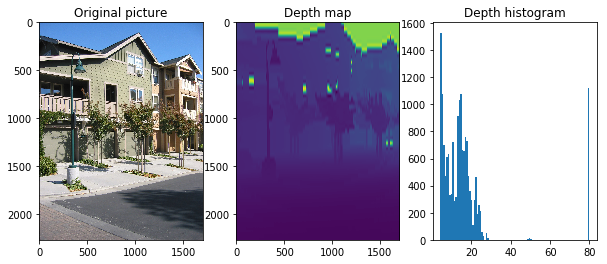

In [8]:
img_path = images[0]

# y_ is the original depth data
X, y, y_ = open_image(img_path)

show_image(X, y, y_)
depth_stats(y_)

Second image.

Range: 3.18-81.92
Mean: 24.721
Variance: 867.326
Skewness: 1.349
Kurtosis: -0.008


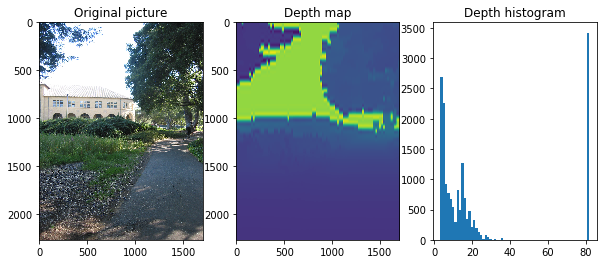

In [9]:
img_path = images[1]

# y_ is the original depth data
X, y, y_ = open_image(img_path)

show_image(X, y, y_)
depth_stats(y_)

It seems that the maximum depth perceived by the laser scanner is around **80 meters**. In order to have more insightful histograms, I will limit to only consider depth values less than 80 meters.  
Let's see how this changes the statistics for the second image.

Range: 3.18-36.18
Mean: 10.081
Variance: 37.641
Skewness: 0.830
Kurtosis: 0.072


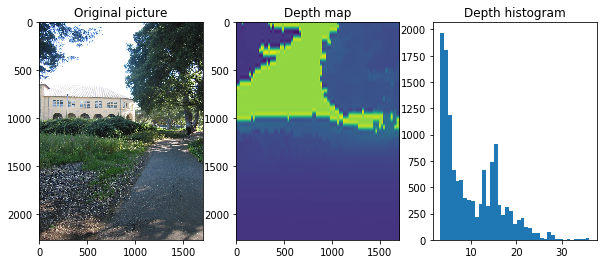

In [10]:
show_image(X, y, y_, max_depth=80)
depth_stats(y_, max_depth=80)

The next depth value after 80 for the second image is **36.18**. By excluding all values **>=80**, we obtain a much smaller variance.  
The average pixel distance for pixels that are in range of the laser scanner is around 10 meters.

Let's test it out on the third image.

Range: 3.33-56.13
Mean: 12.612
Variance: 144.415
Skewness: 2.080
Kurtosis: 3.335


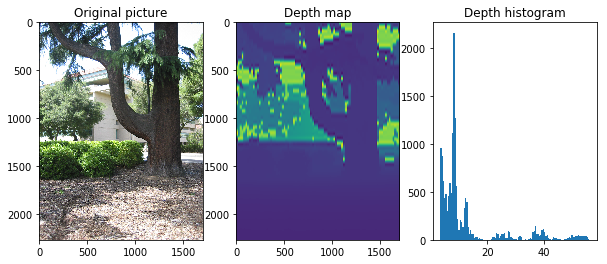

In [11]:
img_path = images[2]

# y_ is the original depth data
X, y, y_ = open_image(img_path)

show_image(X, y, y_, max_depth=80)
depth_stats(y_, max_depth=80)

Here are some more images from the dataset.

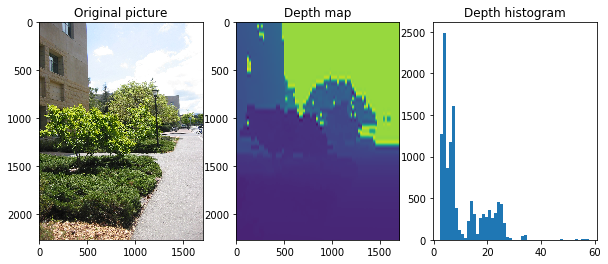

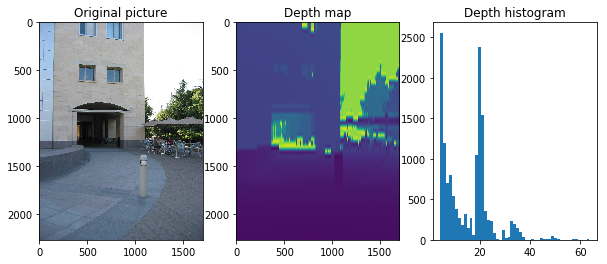

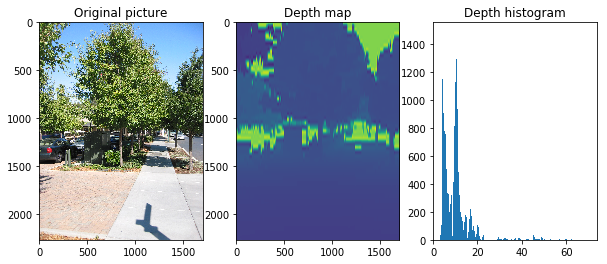

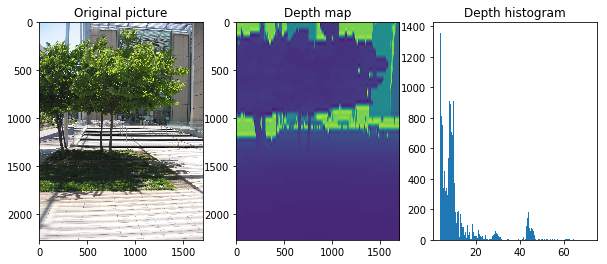

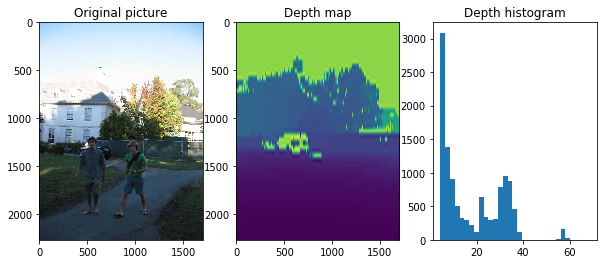

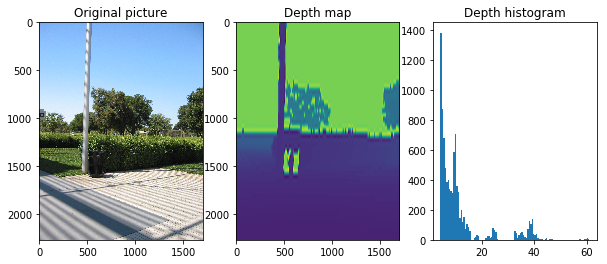

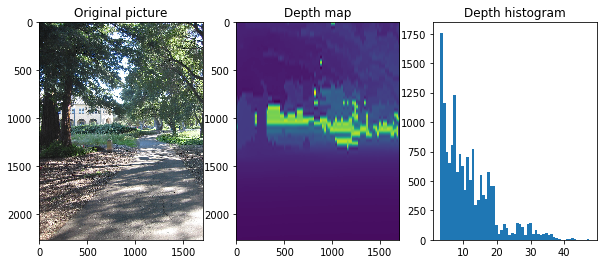

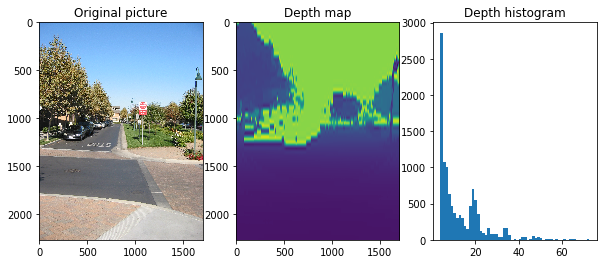

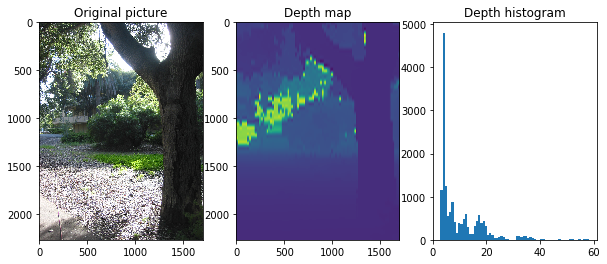

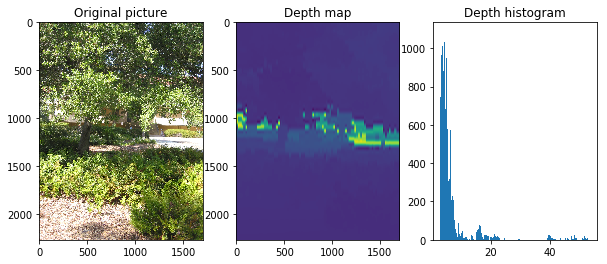

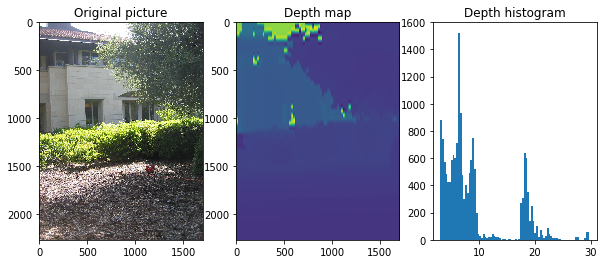

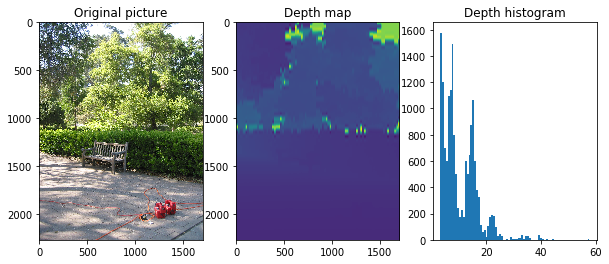

In [12]:
for img_path in images[4:200:17]:
    # y_ is the original depth data
    X, y, y_ = open_image(img_path)
    show_image(X, y, y_, max_depth=80)